## Segment Anything Model for Camouflaged Object Detection
Camouflaged Object Detection (COD) is a segmentation task applied on images where the object of interest is camouflaged against the background. This notebook tries to use Segment Anything Model (SAM) for COD task on COD10k dataset.

In [3]:
import os
import cv2
import sys
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from torch.nn.functional import threshold, normalize
from PIL import Image
from pathlib import Path
from tqdm.auto import tqdm

from segment_anything import sam_model_registry
from segment_anything import SamAutomaticMaskGenerator
from segment_anything import SamPredictor
from segment_anything.utils.transforms import ResizeLongestSide

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device is {device}")

device is cuda


## 1. Data

### 1.1 Look through COD10k

In [ ]:
for dirpath, dirnames, filenames in os.walk('/kaggle/input/cod10k'):
    #print(f"{dirpath}: contains {len(dirnames)} directories")
    if len(dirnames)==0:
        print(f"{dirpath} --> {len(filenames)} images")
    else:
        pass#print(f"{dirpath} --> {len(dirnames)} directories: {dirnames}")

### 1.2 Plot sample images

A sample image and it's corresponding ground truth mask are randomly picked from the Train directory of COD10K.

In [5]:
cod_path = Path("/kaggle/input/cod10k")
train_img_path = cod_path/"COD10K-v2/Train/Images/Image"
train_gt_path = cod_path/"COD10K-v2/Train/GT_Objects/GT_Object"
test_img_path = cod_path/"COD10K-v2/Test/Images/Image"
test_gt_path = cod_path/"COD10K-v2/Test/GT_Objects/GT_Object"

train_img_list = sorted(list(train_img_path.glob("*.jpg")))
train_gt_list = sorted(list(train_gt_path.glob("*.png")))
test_img_list = sorted(list(test_img_path.glob("*.jpg")))
test_gt_list = sorted(list(test_gt_path.glob("*.png")))

Random index = 113, Image size_HxW = (738, 1024)


(-0.5, 1023.5, 737.5, -0.5)

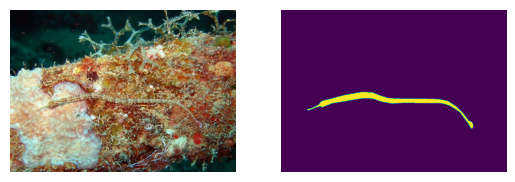

In [9]:
random_idx = random.randint(0,len(train_img_list))
#random_idx = 113
sample_img = train_img_list[random_idx]
sample_gt = train_gt_list[random_idx]
#sample_gt = train_gt_path/f"{sample_img.name[:len(sample_img.name)-3]}png"
(sample_img, sample_gt)

img = Image.open(sample_img)
gt = Image.open(sample_gt)

print(f"Random index = {random_idx}, Image size_HxW = {tuple(reversed(img.size))}")

plt.subplot(1,2,1)
plt.imshow(np.asarray(img))
plt.axis(False)
plt.subplot(1,2,2)
plt.imshow(np.asarray(gt))
plt.axis(False)

### 1.3 Dataset and Dataloader

In [11]:
        
'''
class CamouflageDataset(Dataset):
    def __init__(
        self,
        root_dir: str,
        split: str,
        sam_model: Sam
    ):
        self.root_dir = Path(root_dir)
        self.model = sam_model
        self.device = sam_model.device
        self.transform = ResizeLongestSide(sam_model.image_encoder.img_size)
                
        if split=="train":
            self.data_dir = self.root_dir/"Train"
        elif split=="test":
            self.data_dir = self.root_dir/"Test"
        
        self.image_dir = self.data_dir/"Images/Image"
        self.gt_dir = self.data_dir/"GT_Objects/GT_Object"
        
        self.unsorted_image_list = list(self.image_dir.glob("*.jpg"))
        self.unsorted_gt_list = list(self.gt_dir.glob("*.png"))
        
        self.sorted_image_list = sorted(self.unsorted_image_list)
        self.sorted_gt_list = sorted(self.unsorted_gt_list)
        
        #print(f"sorted_gt_list : { len(self.sorted_gt_list)}")
        #print(f"sorted_image_list : { len(self.sorted_image_list)}")

        #print(self.sorted_image_list[0:5])
        #print(self.sorted_gt_list[0:5])
        
        assert (len(self.sorted_image_list)==len(self.sorted_gt_list)), "Number of Images and Ground Truths are not same!"
    
    def __getitem__(self, idx):
        
        img = Image.open(self.sorted_image_list[idx])
        gt = Image.open(self.sorted_gt_list[idx])
        print(f"img: {type(img),img.size}")
        print(f"gt: {type(gt),gt.size}")
        img_np = np.asarray(img.convert("RGB"), dtype=np.uint8)
        gt_np = np.asarray(gt, dtype=np.uint8)
        print(f"img_np: {type(img_np),img_np.shape}")
        print(f"gt_np: {type(gt_np),gt_np.shape}")        
        img_transformed = self.transform.apply_image(img_np)
        gt_transformed = self.transform.apply_image(gt_np)
        print(f"img_transformed: {type(img_transformed),img_transformed.shape}")
        print(f"gt_transformed: {type(gt_transformed),gt_transformed.shape}")
        img_tensor = torch.as_tensor(img_transformed, device=self.device).permute(2, 0, 1)
        gt_tensor = torch.as_tensor(gt_transformed, device=self.device)
        print(f"img_tensor: {type(img_tensor),img_tensor.shape, img_tensor.dtype}")
        print(f"gt_tensor: {type(gt_tensor),gt_tensor.shape, gt_tensor.dtype}")
        img_preprocessed = self.model.preprocess(img_tensor)
        gt_preprocessed = self._preprocess_gt(gt_tensor)
        print(f"img_preprocessed: {type(img_preprocessed),img_preprocessed.shape, img_preprocessed.dtype}")
        print(f"gt_preprocessed: {type(gt_preprocessed),gt_preprocessed.shape,gt_preprocessed.dtype}")
        
        img_dict = {'image':img_transformed,
                    'raw_size': tuple(reversed(img.size)),
                    #'original_size': image_transform.transforms[0].size,
                    'point_coords': None,
                    'point_labels': None,
                    'boxes': None,
                    'mask_inputs': None 
                   }
        #return img_dict,gt_transformed
        return img_preprocessed,gt_preprocessed
    
    def _preprocess_gt(self, gt_tensor):
        """
        Pads the ground truth to make it a square
        """
        h, w = gt_tensor.shape[-2:]
        padh = self.model.image_encoder.img_size - h
        padw = self.model.image_encoder.img_size - w
        gt_preprocessed = F.pad(gt_tensor, (0, padw, 0, padh)).unsqueeze(dim=0).to(torch.float32)
        return gt_preprocessed
    
    def __len__(self):
        return len(self.sorted_image_list)
'''
class CamouflageDataset(Dataset):
    def __init__(
        self,
        root_dir: str,
        image_transform: transforms.Compose,
        split: str
    ):
        self.root_dir=Path(root_dir)
        self.image_transform = image_transform
        
        if split=="train":
            self.data_dir = self.root_dir/"Train"
        elif split=="test":
            self.data_dir = self.root_dir/"Test"
        
        self.image_dir = self.data_dir/"Images/Image"
        self.gt_dir = self.data_dir/"GT_Objects/GT_Object"
        
        self.unsorted_image_list = list(self.image_dir.glob("*.jpg"))
        self.unsorted_gt_list = list(self.gt_dir.glob("*.png"))
        
        self.sorted_image_list = sorted(self.unsorted_image_list)
        self.sorted_gt_list = sorted(self.unsorted_gt_list)
        
        #print(f"sorted_gt_list : { len(self.sorted_gt_list)}")
        #print(f"sorted_image_list : { len(self.sorted_image_list)}")

        #print(self.sorted_image_list[0:5])
        #print(self.sorted_gt_list[0:5])
        
        assert (len(self.sorted_image_list)==len(self.sorted_gt_list)), "Number of Images and Ground Truths are not same!"
    
    def __getitem__(self, idx):
        img = Image.open(self.sorted_image_list[idx])
        gt = Image.open(self.sorted_gt_list[idx])
        
        img = self.image_transform(img)
        gt = self.image_transform(gt)
        
        return img,gt
    
    def __len__(self):
        return len(self.sorted_image_list)


In [12]:
image_transform = transforms.Compose([transforms.Resize((512,512)), transforms.ToTensor()])

train_dataset = CamouflageDataset(
    root_dir="/kaggle/input/cod10k/COD10K-v2",
    image_transform=image_transform,
    split="train"
)

test_dataset = CamouflageDataset(
    root_dir="/kaggle/input/cod10k/COD10K-v2",
    image_transform=image_transform,
    split="test"
)

In [ ]:
#len(train_dataset), len(test_dataset)

In [13]:
train_dataloader=DataLoader(train_dataset,batch_size=4, shuffle=True)
test_dataloader=DataLoader(test_dataset,batch_size=4, shuffle=False)

## 2. Zero-shot Learning

### 2.1 Pre-trained Model (SAM)

In [14]:
for dirpath, dirnames, filenames in os.walk("/kaggle/input/segment-anything"):
    print(dirnames)

['pytorch']
['vit-l', 'vit-h', 'vit-b']
['1']
[]
['1']
[]
['1']
[]


Loading the SAM model ViT-b, ViT-l, ViT-h from the respective check points.

In [15]:
#sam_checkpoint_b = "/kaggle/input/segment-anything/pytorch/vit-b/1/model.pth"
sam_checkpoint_l = "/kaggle/input/segment-anything/pytorch/vit-l/1/model.pth"
#sam_checkpoint_h = "/kaggle/input/segment-anything/pytorch/vit-h/1/model.pth"
#model_type = "vit_b"
#sam_b = sam_model_registry["vit_b"](checkpoint=sam_checkpoint_b)
sam_l = sam_model_registry["vit_l"](checkpoint=sam_checkpoint_l)
#sam_h = sam_model_registry["vit_h"](checkpoint=sam_checkpoint_h)
#sam_b.to(device)
sam_l.to(device)
#sam_h.to(device)
pass
#summary(model=sam_b, col_names=['num_params','trainable'])
#summary(model=sam_l)
#summary(model=sam_h, col_names=['num_params','trainable'])

### 2.2 Mask prediction (Inference)

Passing the sample image (as a numpy array) to the model through SamPredictor.

In [17]:
img_np = np.asarray(img.convert("RGB"))

#predictor_b = SamPredictor(sam_model=sam_b)
predictor_l = SamPredictor(sam_model=sam_l)
#predictor_h = SamPredictor(sam_model=sam_h)

#predictor_b.set_image(img_np)
predictor_l.set_image(img_np)
#predictor_h.set_image(img_np)

#masks_b = predictor_b.predict()
masks_l = predictor_l.predict()
#masks_h = predictor_h.predict()

In [18]:
img_np.shape

(738, 1024, 3)

In [ ]:
#img = cv2.imread(str(sample_img))
#auto_mask_generator_b = SamAutomaticMaskGenerator(sam_b)
auto_mask_generator_l = SamAutomaticMaskGenerator(sam_l)
#auto_mask_generator_h = SamAutomaticMaskGenerator(sam_h)
#masks_amg_b = auto_mask_generator_b.generate(img_np)
masks_amg_l = auto_mask_generator_l.generate(img_np)
#masks_amg_h = auto_mask_generator_h.generate(img_np)

In [ ]:
# Plotting the sample Image and Ground truth
plt.subplot(1,2,1)
plt.imshow(np.asarray(img))
plt.axis(False)
plt.subplot(1,2,2)
plt.imshow(np.asarray(gt))
plt.axis(False)

In [ ]:
# Plotting Plotting sam_b's masks using SamPredictor
g_b = int(np.sqrt(len(masks_b[0]))+1) # max grid size
for i in range(len(masks_b[0])):
    #plt.figure(figsize=(10,10))
    plt.subplot(g_b,g_b,i+1)
    plt.imshow(masks_b[0][i,:,:])
    plt.axis(False)
    plt.title(f"Mask quality = {masks_b[1][i]:.4f}")

In [ ]:
# Plotting Plotting sam_l's masks using SamPredictor
g_l = int(np.sqrt(len(masks_l[0]))+1) # max grid size
for i in range(len(masks_l[0])):
    #plt.figure(figsize=(10,10))
    plt.subplot(g_l,g_l,i+1)
    plt.imshow(masks_l[0][i,:,:])
    plt.axis(False)
    plt.title(f"Mask quality = {masks_l[1][i]:.4f}")


In [ ]:
# Plotting Plotting sam_h's masks using SamPredictor
g_h = int(np.sqrt(len(masks_h[0]))+1) # max grid size
for i in range(len(masks_h[0])):
    #plt.figure(figsize=(10,10))
    plt.subplot(g_h,g_h,i+1)
    plt.imshow(masks_h[0][i,:,:])
    plt.axis(False)
    plt.title(f"Mask quality = {masks_h[1][i]:.4f}")


In [ ]:
# Plotting sam_b's masks using SamAutomaticMaskGenerator
g_b = int(np.sqrt(len(masks_amg_b[0]))+1) # max grid size
for i in range(len(masks_amg_b[0])):
    #plt.figure(figsize=(10,10))
    plt.subplot(g_b,g_b,i+1)
    plt.imshow(masks_amg_b[i]['segmentation'])
    plt.axis(False)
    plt.title(f"SS:{masks_amg_b[i]['stability_score']:.3f},IoU:{masks_amg_b[i]['predicted_iou']:.3f}")

In [ ]:
# Plotting sam_l's masks using SamAutomaticMaskGenerator
g_l = int(np.sqrt(len(masks_amg_l[0]))+1) # max grid size
for i in range(len(masks_amg_l[0])):
    #plt.figure(figsize=(10,10))
    plt.subplot(g_l,g_l,i+1)
    plt.imshow(masks_amg_l[i]['segmentation'])
    plt.axis(False)
    plt.title(f"SS:{masks_amg_l[i]['stability_score']:.3f},IoU:{masks_amg_l[i]['predicted_iou']:.3f}")

In [ ]:
# Plotting sam_h's masks
g_h = int(np.sqrt(len(masks_amg_h[0]))+1) # max grid size
for i in range(len(masks_amg_h[0])):
    #plt.figure(figsize=(10,10))
    plt.subplot(g_h,g_h,i+1)
    plt.imshow(masks_amg_h[i]['segmentation'])
    plt.axis(False)
    plt.title(f"SS:{masks_amg_h[i]['stability_score']:.3f},IoU:{masks_amg_h[i]['predicted_iou']:.3f}")

## 3. Few-shot Learning

### 3.1 Prepare SAM (vit-h) for fine tuning

Freezing the parameters of Image Encoder and Prompt Decoder while allowing the parameters of the Mask Decoder to be updated.

In [ ]:
sam_checkpoint_h = "/kaggle/input/segment-anything/pytorch/vit-h/1/model.pth"
sam_h = sam_model_registry["vit_h"](checkpoint=sam_checkpoint_h)
sam_h.to(device)
pass

In [ ]:
sam_h.device

In [ ]:
# Freeze Image Encoder and Prompt Encoder
for param in sam_h.image_encoder.parameters():
    param.requires_grad = False

for param in sam_h.prompt_encoder.parameters():
    param.requires_grad = False

In [ ]:
summary(model=sam_h, col_names=['num_params','trainable'])

### 3.2 Prepare Data Loader

In [ ]:
class CamouflageDataset(Dataset):
    def __init__(
        self,
        root_dir: str,
        image_transform: transforms.Compose,
        split: str
    ):
        self.root_dir=Path(root_dir)
        self.image_transform = image_transform
                
        if split=="train":
            self.data_dir = self.root_dir/"Train"
        elif split=="test":
            self.data_dir = self.root_dir/"Test"
        
        self.image_dir = self.data_dir/"Images/Image"
        self.gt_dir = self.data_dir/"GT_Objects/GT_Object"
        
        self.unsorted_image_list = list(self.image_dir.glob("*.jpg"))
        self.unsorted_gt_list = list(self.gt_dir.glob("*.png"))
        
        self.sorted_image_list = sorted(self.unsorted_image_list)
        self.sorted_gt_list = sorted(self.unsorted_gt_list)
        
        #print(f"sorted_gt_list : { len(self.sorted_gt_list)}")
        #print(f"sorted_image_list : { len(self.sorted_image_list)}")

        #print(self.sorted_image_list[0:5])
        #print(self.sorted_gt_list[0:5])
        
        assert (len(self.sorted_image_list)==len(self.sorted_gt_list)), "Number of Images and Ground Truths are not same!"
    
    def __getitem__(self, idx):
        
        img = Image.open(self.sorted_image_list[idx])
        gt = Image.open(self.sorted_gt_list[idx])
        
        #img_np = np.asarray(img.convert("RGB"))
        #gt_np = np.asarray(gt.convert("RGB"))
        
        img_transformed = self.image_transform(img).to(device)
        gt_transformed = self.image_transform(gt).to(device)
        
        img_dict = {'image':img_transformed,
                    'raw_size': tuple(reversed(img.size)),
                    'original_size': image_transform.transforms[0].size
                    #'point_coords': ,
                    #'point_labels': ,
                    #'boxes': ,
                    #'mask_inputs':  
                   }
        
        #print(f"original_size: {type(img_np.shape[0:2])}")
        #print('____________')
        #print(img_dict)
        #print('____________')
        
        #return gt_transformed, img_transformed
        return img_dict,gt_transformed
    
    def __len__(self):
        return len(self.sorted_image_list)
     

In [ ]:
#image_transform = transforms.Compose([transforms.Resize((1024,1024))])
image_transform = transforms.Compose([transforms.Resize((1024,1024)), transforms.ToTensor()])
#image_transform = ResizeLongestSide(target_length=sam_h.image_encoder.img_size)

train_dataset = CamouflageDataset(
    root_dir="/kaggle/input/cod10k/COD10K-v2",
    image_transform=image_transform,
    split="train"
)

test_dataset = CamouflageDataset(
    root_dir="/kaggle/input/cod10k/COD10K-v2",
    image_transform=image_transform,
    split="test"
)


In [ ]:
train_dataloader = DataLoader(train_dataset,batch_size=3, shuffle=True)
test_dataloader = DataLoader(test_dataset,batch_size=3, shuffle=False)

In [ ]:
img_dict, gt  = next(iter(train_dataloader))

In [ ]:
img_dict['raw_size']

In [ ]:
def prep_batched_input(img_dict, gt):
    """
    Prepares a List(Dict) over images in the format suitable for SAM.
    
    Arguments: img_dict (dict[str:list]): A dict with following key-value pairs
                    'image'        : (list(torch.Tensor)) A list of images in the batch
                    'original_size': (list(torch.Tensor, torch.Tensor)) both the tensors of size B
                                     A list of image sizes from dataloader. [H's, W's] (=1024x1024)
                    'raw_size'     : (list(torch.Tensor, torch.Tensor)) both the tensors of size B
                                     A list of image sizes from cod10k. [H's, W's]
                gt (torch.Tensor): Batch of ground truths from dataloader (Bx1XHxW)
    Returns: batched_input (list[dict[str:__]]): A list over images, each a dict with following keys
                'image'        : (torch.Tensor) An image as a torch tensor in 3xHxW shape (=3x1024x1024),
                'original_size': (tuple(torch.Tensor, torch.Tensor)) The size from dataloader(H,W)(=1024x1024)
                'raw_size'     : (tuple(torch.Tensor, torch.Tensor)) The size from cod10k(H,W)
    """
    batch_size = len(gt)
    batched_input = []
    for i in range(batch_size):
        #print(i)
        img_dict_new = {'image': img_dict['image'][i],
                        'original_size': (img_dict['original_size'][0][i],img_dict['original_size'][1][i]),
                        'raw_size': (img_dict['raw_size'][0][i],img_dict['raw_size'][1][i])
                        #'point_coords': ,
                        #'point_labels': ,
                        #'boxes': ,
                        #'mask_inputs': 
                       }
        #print(f"before append: {len(batched_input)}")
        batched_input.append(img_dict_new)
        #print(f"after append: {len(batched_input)}")
    return batched_input

In [ ]:
'''
#img_np = np.asarray(img.convert("RGB"))
#print(f"img: type={type(img)}, shape={img.size}")
#print(f"img_np: type={img_np.dtype}, shape={img_np.shape}")
input_image = image_transform.apply_image(img_np)
print(f"input_image: type={input_image.dtype}, shape={input_image.shape}")
input_image_torch = torch.as_tensor(input_image, device=device, dtype=torch.float)
#print(input_image_torch.shape)
input_image_torch = input_image_torch.permute(2, 0, 1).contiguous()[None, :, :, :]
print(f"input_image_torch: type={input_image_torch.dtype}, shape={input_image_torch.shape}")
input_image_preprocessed = sam_h.preprocess(input_image_torch)
print(f"input_image_preprocessed: type={input_image_preprocessed.dtype}, shape={input_image_preprocessed.shape}")
'''

In [ ]:
with torch.no_grad():
    image_embedding = sam_h.image_encoder(input_image_preprocessed)

image_embedding.shape

with torch.no_grad():
      sparse_embeddings, dense_embeddings = sam_h.prompt_encoder(
          points=None,
          boxes=None,
          masks=None,
      )

low_res_masks, iou_predictions = sam_h.mask_decoder(
    image_embeddings=image_embedding,
    image_pe=sam_h.prompt_encoder.get_dense_pe(),
    sparse_prompt_embeddings=sparse_embeddings,
    dense_prompt_embeddings=dense_embeddings,
    multimask_output=False
)

upscaled_masks = sam_h.postprocess_masks(
    masks=low_res_masks,
    input_size=input_image.shape[0:2],
    original_size=img_np.shape[0:2]
).to(device)

binary_masks = normalize(threshold(upscaled_masks, 0.0, 0)).to(device)

In [ ]:
img_dict,gt = next(iter(train_dataloader))
batched_input = prep_batched_input(img_dict, gt)
masks = sam_h(batched_input=batched_input, multimask_output=False)

In [ ]:
batched_input = prep_batched_input(img_dict, gt)

In [ ]:
batched_input[0]['raw_size']

In [ ]:
def assert_mask_dims(batched_input, masks):
    for i in range(len(masks)):
        assert len(masks)==len(batched_input),"Length of 'masks' and 'batched_input' doesn't match!"
        assert batched_input[i]['raw_size'] == masks[0]['masks'].shape[-2:], "mask size mismatch @ index {i}"

In [ ]:
def resize_to_actual_size(batched_input, masks, gts):
    """
    Resizes the predicted masks and ground truths to actual sizes using raw_size from batched_input.
    
    Arguments: batched_input (list[dict[str:__]]): A list over images, each a dict with following keys
                 'image'        : (torch.Tensor) An image as a torch tensor in 3xHxW shape (=3x1024x1024),
                 'original_size': (tuple(torch.Tensor, torch.Tensor)) The size from dataloader(H,W)(=1024x1024)
                 'raw_size'     : (tuple(torch.Tensor, torch.Tensor)) The size from cod10k(H,W)
                masks (list(dict[str:__])) : masks from the output of SAM
                gts
                
    """
    assert len((masks))
    final_masks = []
    final_gts = []
    for i in range(len(masks)):
        final_mask = {
            'masks': transforms.Resize(batched_input[i]['raw_size'])(masks[i]['masks']).squeeze(dim=0),
            'iou_predictions': masks[i]['iou_predictions'],
            'low_res_logits': masks[i]['low_res_logits']
        }
        final_gt = transforms.Resize(batched_input[i]['raw_size'])(gts[i])
        final_masks.append(final_mask)
        final_gts.append(final_gt)
    return final_masks, final_gts
    

In [ ]:
final_masks = make_final_masks(batched_input=batched_input, masks=masks)

In [ ]:
masks[0]['masks'].shape, final_masks[0]['masks'].shape

In [ ]:
batched_input[0]['raw_size']

In [ ]:
gt[0].shape

### 3.3 Training Loop

In [ ]:
NUM_EPOCHS = 1

for epoch in range(NUM_EPOCHS):
    print(f"Epoch - {epoch+1}")
    for batch, (img_dict, gt) in enumerate(tqdm(train_dataloader)):
        batched_input = prep_batched_input(img_dict, gt)
        masks = sam_h(batched_input=batched_input, multimask_output=False)
        
        #print(batch,type(img_dict))

## Conclusion
Keep re-running the cells from section 1.2 onwards to randomly pick a different sample image each time.
* It is observed... only occasionlly, among all the valid masks produced by SAM is the ground truth COD mask
* However, i believe... by customizing the downstream task and transfer learning, SAM is likely to perform well for COD task